In [67]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(Array([2, 1], dtype=int32),
 Array([[1, 2]], dtype=int32),
 Array([1, 0], dtype=int32))

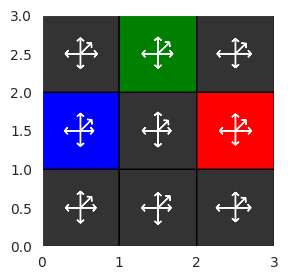

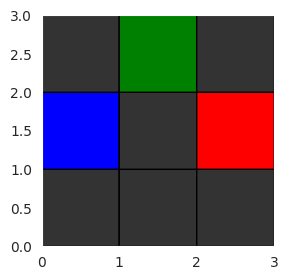

In [68]:
from types import SimpleNamespace
import os
os.environ['CUDA'] = '/usr/local/cuda-12'
os.environ['PATH'] = '/usr/local/cuda-12/bin${PATH:+:${PATH}}'

import jax as jx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps
import json
import environments
import math
from vq_vae import *
import pickle as pkl

with open('configs/EW_VQVAE_simple_model.json', 'r') as f:
    config = json.load(f)

def render(state):
    goal, enemy_coords, pos = state
    cmap = colors.ListedColormap(['#333333','red', 'green', 'blue'])
    arr = np.zeros((env.grid_size, env.grid_size))
    arr[goal[0], goal[1]] = 2
    arr[pos[0], pos[1]] = 3
    for enemy_coord in enemy_coords:
        arr[enemy_coord[0], enemy_coord[1]] = 1
    plt.figure(figsize=(3,3))
    plt.pcolor(arr, cmap=cmap, edgecolors='k', linewidths=1, vmin=0, vmax=3)

def render_q(stat):
    render(stat)
    scale = 1
    goal, enemy_coords, player = stat
    move_map = env.move_map.astype(float)
    move_map = move_map.at[0].set([1/math.sqrt(2), 1/math.sqrt(2)]) # plot inaction as diagonal
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            player = jnp.array((i, j))
            ob = env.get_observation((goal, enemy_coords, player))
            qs = Q_func(params['Q'][seed_id], ob)
            qs = jx.nn.softmax(qs)

            for a, q in enumerate(qs):
                arr_dir = move_map[a]
                plt.arrow(player[1] + 0.5, player[0] + 0.5, scale*arr_dir[1]*q, scale*arr_dir[0]*q, head_width=0.09, head_length=0.04, length_includes_head=True, color='white', overhang=1)

def render_obs(obs, ax=None):
    grid_shape = (env.grid_size, env.grid_size)
    obs2 = np.reshape(np.array(obs, dtype=int), (*grid_shape, 4))
    player, goal, enemy = obs2[:,:,0], obs2[:,:,1], obs2[:,:,2]
    cmap = colors.ListedColormap(['#333333','red', 'green', 'blue'])
    arr = np.zeros(grid_shape)
    arr += enemy
    arr = np.maximum(arr, goal * 2)
    arr = np.maximum(arr, player * 3)
    if ax is None:
        plt.figure(figsize=(3,3))
        plt.pcolor(arr, cmap=cmap, edgecolors='k', linewidths=1, vmin=0, vmax=3)
    else:
        ax.pcolor(arr, cmap=cmap, edgecolors='k', linewidths=1, vmin=0, vmax=3)


def set_default(d, k, v):
    if k not in d:
        d[k] = v

set_default(config, "double_DQN", False)
set_default(config, "episodic_env", False)
set_default(config, "updates_per_step", 1)
set_default(config, "save_final_params", True)
config = SimpleNamespace(**config)

Environment = getattr(environments, config.environment)

env_config = config.env_config

key = jx.random.PRNGKey(1)
seed_id = 4
env = Environment(**env_config)
num_actions = env.num_actions()




with open('out/EW_VQ_VAE_simple_model_prior.params', 'rb') as f:
    params = pkl.load(f)
with open('out/EW_VQ_VAE_simple_model_prior.states', 'rb') as f:
    states = pkl.load(f)

state, obs = env.reset(key)

Q_net = hk.without_apply_rng(hk.transform(lambda obs: Q_function(config, env.num_actions())(obs)))
Q_func = Q_net.apply
render_q(state)
render_obs(obs)
state

(None, None)

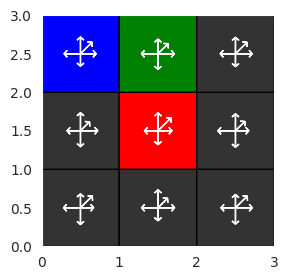

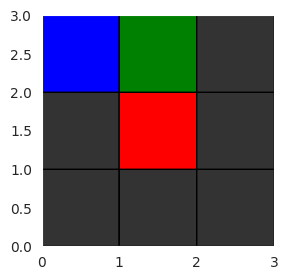

In [69]:
key, subkey = jx.random.split(key)
action0 = 3
new_state, new_obs, rew, terminal, info = env.step(subkey, state, action0)
render_q(new_state), render_obs(new_obs)

In [70]:
dummy_a = jnp.zeros((env.num_actions()))

reward_net = hk.without_apply_rng(hk.transform(lambda obs, a, emb: reward_decoder(config)(obs, a, emb)))
reward_params = params['model'][seed_id]['reward']
reward_func = reward_net.apply

termination_net = hk.without_apply_rng(hk.transform(lambda obs, a, emb: termination_decoder(config)(obs, a, emb)))
termination_params = params['model'][seed_id]['termination']
termination_func = termination_net.apply

next_obs_net = hk.without_apply_rng(
    hk.transform(lambda obs, a, emb, key: next_obs_decoder(config, obs.shape[-1])(obs, a, emb, key)))
next_obs_params = params['model'][seed_id]['next_obs']
next_obs_func = next_obs_net.apply

encoder_net = hk.without_apply_rng(
    hk.transform_with_state(lambda obs, action, next_obs, reward, termination, is_training:
                            Encoder(config)(obs, action, next_obs, reward, termination, is_training)))
encoder_params = params['model'][seed_id]['encoder']
encoder_state = states['model'][seed_id]['encoder']

encoder_func = encoder_net.apply

quantize_fun = hk.without_apply_rng(
    hk.transform_with_state(lambda encoding_indices: Encoder(config).vq.quantize(encoding_indices)))


def prior_func(prior_logits, encoder_params, encoder_state, key):
    out, enc_state = quantize_fun.apply(encoder_params, encoder_state,
                                        jx.random.categorical(key, jnp.log(prior_logits)))
    return jx.lax.stop_gradient(out)
prior_state = states['model'][seed_id]['prior']


model_funcs = {"reward": reward_func, "termination": termination_func, "next_obs": next_obs_func,
               "encoder": encoder_func, "prior": prior_func}

model_params = [{"reward": rp, "termination": tp, "next_obs": no, "encoder": ep} for rp, tp, no, ep in
                zip(reward_params, termination_params, next_obs_params, encoder_params)]

Predicted:


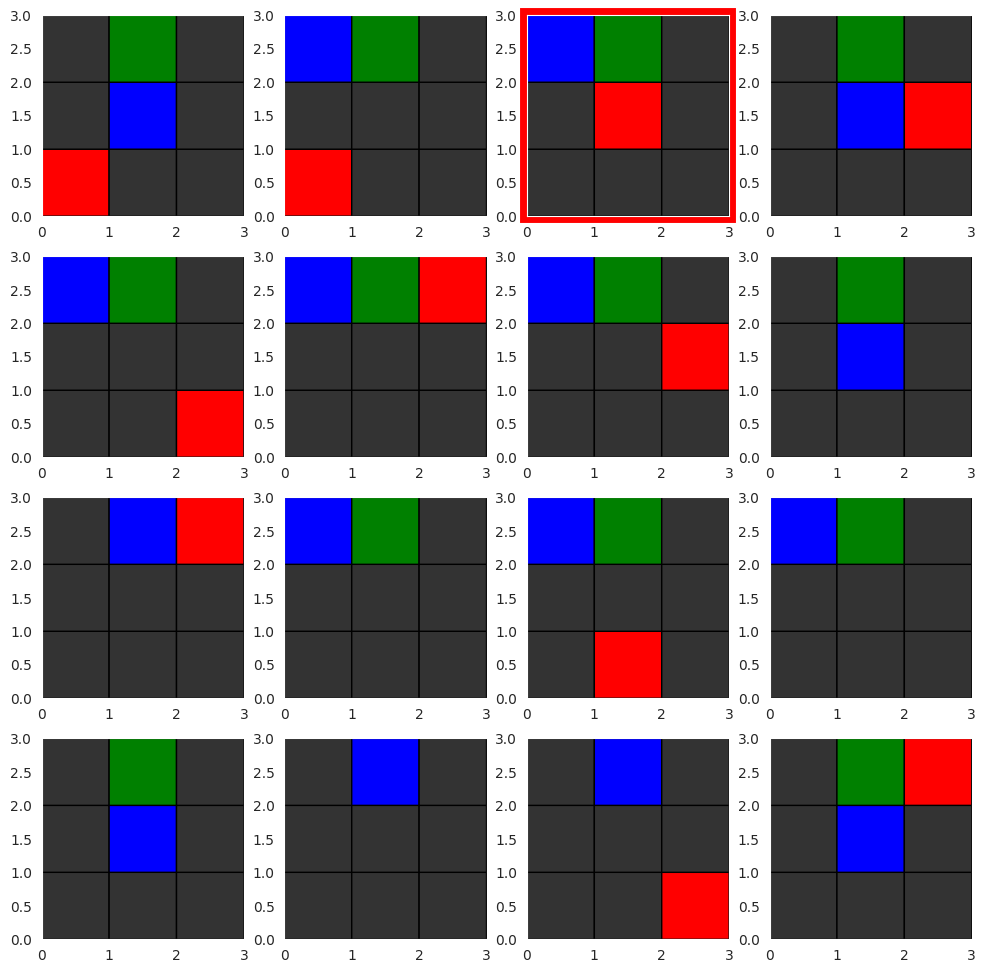

Enemy probs:


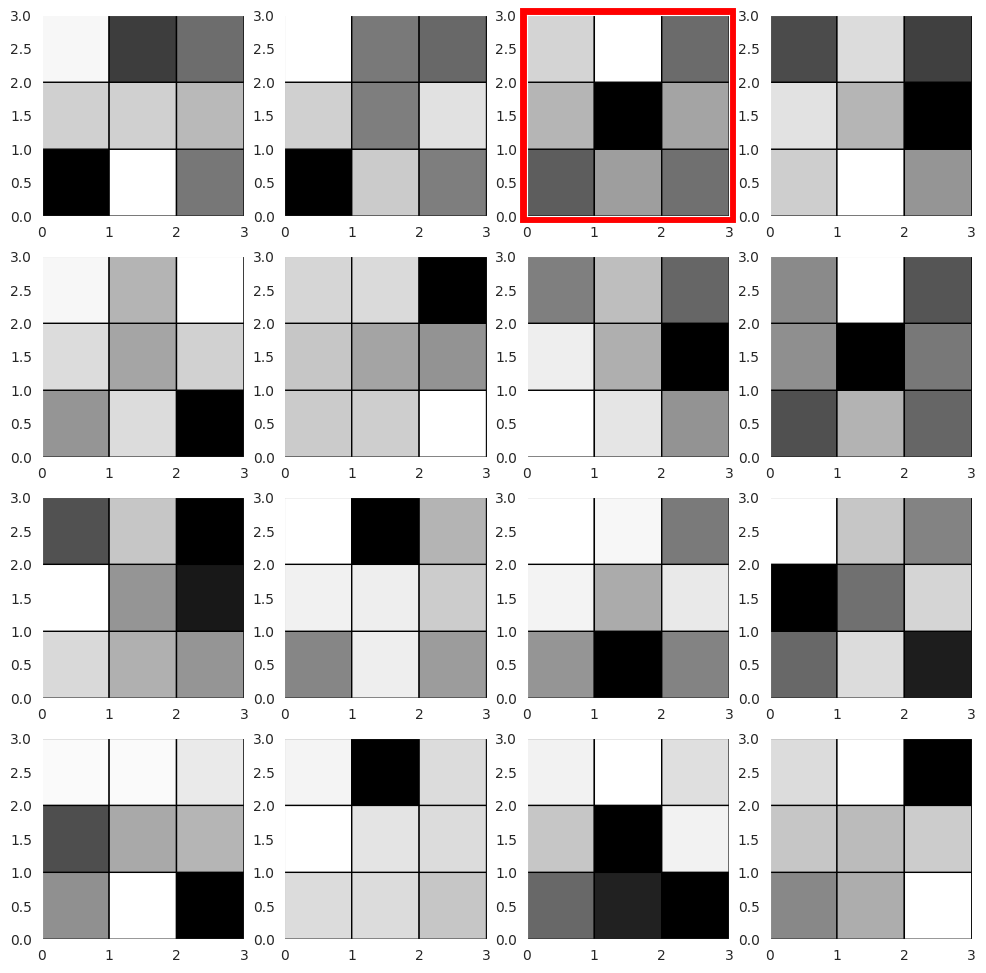

s:


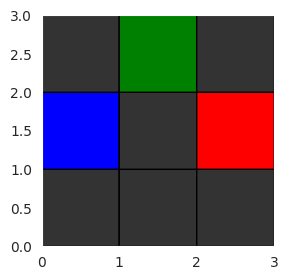

s':


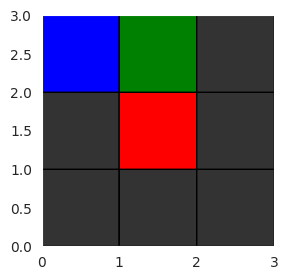

In [71]:
encoded = encoder_func(encoder_params, encoder_state, obs, jnp.eye(num_actions)[action0], new_obs, rew, terminal, False)
encoding_ind = encoded[0]['encoding_indices'].item()

def render_enemy_probs(logits, ax=plt):
    grid_shape = (env.grid_size, env.grid_size)
    obs2 = np.reshape(np.array(logits, dtype=int), (*grid_shape, 4))
    player, goal, enemy = obs2[:,:,0], obs2[:,:,1], obs2[:,:,2]
    arr = np.zeros(grid_shape)
    arr += enemy

    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.pcolor(arr, cmap='Grays', edgecolors='k', linewidths=1)
    # fig.colorbar(im, cax=cax, orientation='vertical')

def draw_border(ax):
    ax.patch.set_linewidth(10)
    ax.patch.set_edgecolor('red')

    # ax.spines['bottom'].set_color('0.5')
    # ax.spines['top'].set_color('0.5')
    # ax.spines['right'].set_color('0.5')
    # ax.spines['left'].set_color('0.5')

print('Predicted:')
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    predicted_obs, logits = next_obs_func(
        next_obs_params,
        obs,
        jnp.eye(num_actions)[action0],
        quantize_fun.apply(encoder_params, encoder_state, i)[0],
        key)
    render_obs(predicted_obs, ax)
    if i == encoding_ind:
       draw_border(ax)
plt.show()
print('Enemy probs:')
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for i, ax in enumerate(np.array(axs).flatten()):
    predicted_obs, logits = next_obs_func(
        next_obs_params,
        obs,
        jnp.eye(num_actions)[action0],
        quantize_fun.apply(encoder_params, encoder_state, i)[0],
        key)
    render_enemy_probs(logits['logit'], ax)
    if i == encoding_ind:
        draw_border(ax)

plt.show()
print('s:')
render_obs(obs)
plt.show()
print("s':")
render_obs(new_obs)

<BarContainer object of 16 artists>

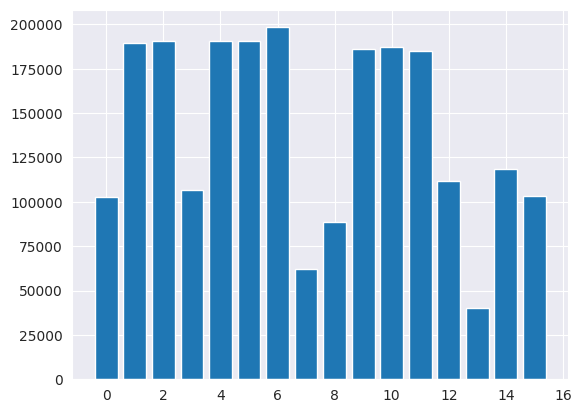

In [72]:
plt.bar(range(16), prior_state)

In [73]:
curr_obs = obs
curr_state = state

Rew: -0.05 {'mu': Array(-0.05947255, dtype=float32), 'sigma': Array(1., dtype=float32)}


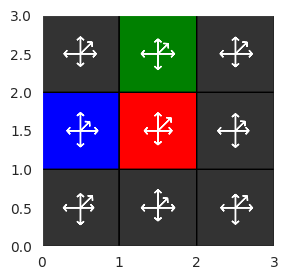

In [74]:
act = 2

prev_state, prev_obs = curr_state, curr_obs
curr_state, curr_obs, curr_rew, cur_terminal, _ = env.step(key, curr_state, act)
render_q(curr_state)
emb = quantize_fun.apply(encoder_params, encoder_state, 0)[0]
print('Rew:', curr_rew, reward_func(reward_params, curr_obs, jnp.eye(num_actions)[act], emb))

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

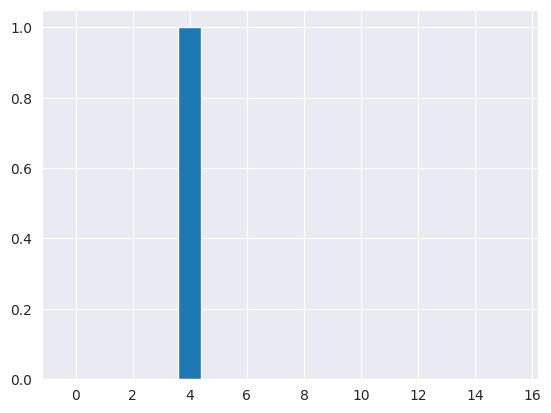

In [75]:
seeds = 1
correct_counts = np.zeros((16,), dtype=int)
for seed in range(seeds):
    key = jx.random.PRNGKey(seed)
    seed_id = 4
    stat, ob = env.reset(key)
    action = jx.random.choice(key, num_actions)
    num_possibly_correct = 0

    for i in range(16):
        goal, enemy_coords, pos = stat
        # render(stat)
        # plt.show()

        predicted_obs, logits = next_obs_func(
            next_obs_params,
            ob,
            jnp.eye(num_actions)[action],
            quantize_fun.apply(encoder_params, encoder_state, i)[0],
            key)
        obs_precise = logits['logit'] > 0
        ac_state, ac_obs, ac_rew, ac_terminal, _ = env.step(subkey, stat, action)
        # print('ac_ob:')
        # render(ac_state)
        plt.show()
        _, _, pos = ac_state
        # print('possibilities:')
        is_possibly_correct = False
        for mov in range(1, 5):
            # Move if the new position is on the grid
            enemy_pos = jnp.clip(enemy_coords + env.move_map[mov], 0, env.grid_size - 1)
            possible_state = (goal, enemy_pos, pos)
            poss_obs = env.get_observation(possible_state)
            if jnp.array_equal(predicted_obs, poss_obs):
                is_possibly_correct = True
                break
        if is_possibly_correct:
            num_possibly_correct += 1
    correct_counts[num_possibly_correct] += 1

plt.bar(range(16), correct_counts)

correct_counts

In [76]:
from collections import Counter

seeds = 1
correct_percentages = []
for seed in range(seeds):
    key = jx.random.PRNGKey(seed)
    seed_id = 4
    stat, ob = env.reset(key)
    goal, enemy_coords, _ = stat
    action = jx.random.choice(key, num_actions)
    ac_state, ac_obs, ac_rew, ac_terminal, _ = env.step(subkey, stat, action)
    _, _, pos = ac_state

    num_possibly_correct = 0

    possible_states = 0
    found_states = 0.0
    for mov in range(1, 5):
        # Move if the new position is on the grid
        enemy_pos = jnp.clip(enemy_coords + env.move_map[mov], 0, env.grid_size - 1)
        if jnp.array_equal(enemy_pos, enemy_coords):
            continue
        possible_states += 1
        possible_state = (goal, enemy_pos, pos)
        poss_obs = env.get_observation(possible_state)

        # print("possible_state")
        # render(possible_state)
        # plt.show()

        for i in range(16):
            predicted_obs, logits = next_obs_func(
                next_obs_params,
                ob,
                jnp.eye(num_actions)[action],
                quantize_fun.apply(encoder_params, encoder_state, i)[0],
                key)
            obs_precise = logits['logit'] > 0

            if jnp.array_equal(predicted_obs, poss_obs):
                # print("predicted")
                # render_obs(predicted_obs)
                # plt.show()
                found_states += 1
                break

    correct_percentages.append(found_states / possible_states)

Counter(correct_percentages)

Counter({1.0: 1})

In [77]:
x = Counter(correct_percentages)
{k: v for k, v in sorted(x.items(), key=lambda item: item[0])}

{1.0: 1}

In [78]:
from jax import vmap
from operator import getitem


def cross_entropy_loss(logits, labels):
    logits = jx.nn.log_softmax(logits['logits'])
    loss = vmap(getitem)(logits, labels)
    loss = -loss.mean()
    return loss

import jax.random as rand

key = rand.PRNGKey(42)

x = rand.normal(key, (16, 10))
y = rand.randint(key, (16,), 0, 10)

x_logits = {'logits': x}

print(cross_entropy_loss(x_logits, y))

x.shape, y.shape

2.8889012


((16, 10), (16,))

<BarContainer object of 16 artists>

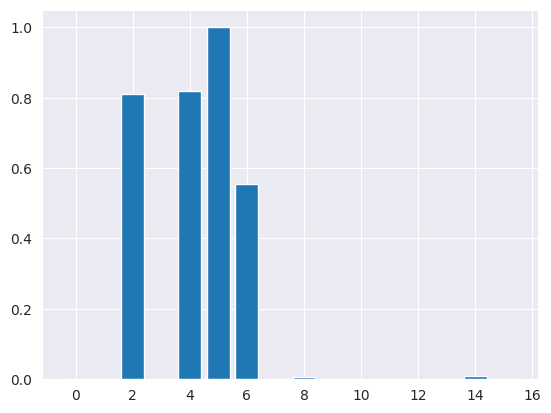

In [79]:
# k = jx.random.PRNGKey(16)
# seed_id = 6
# s, o = env.reset(k)

embedding_prior_net = hk.without_apply_rng(
    hk.transform(lambda obs, a: embedding_prior(config)(obs, a)))
embedding_prior_func = embedding_prior_net.apply

embedding_prior_params = params['mi'][seed_id]['embedding_prior']

prior_probs = embedding_prior_func(embedding_prior_params, obs, jnp.eye(num_actions)[0])['logits']
def map01(arr):
    return arr / jnp.max(arr)

plt.bar(range(16), map01(jx.nn.softmax(prior_probs)))


Predicted:


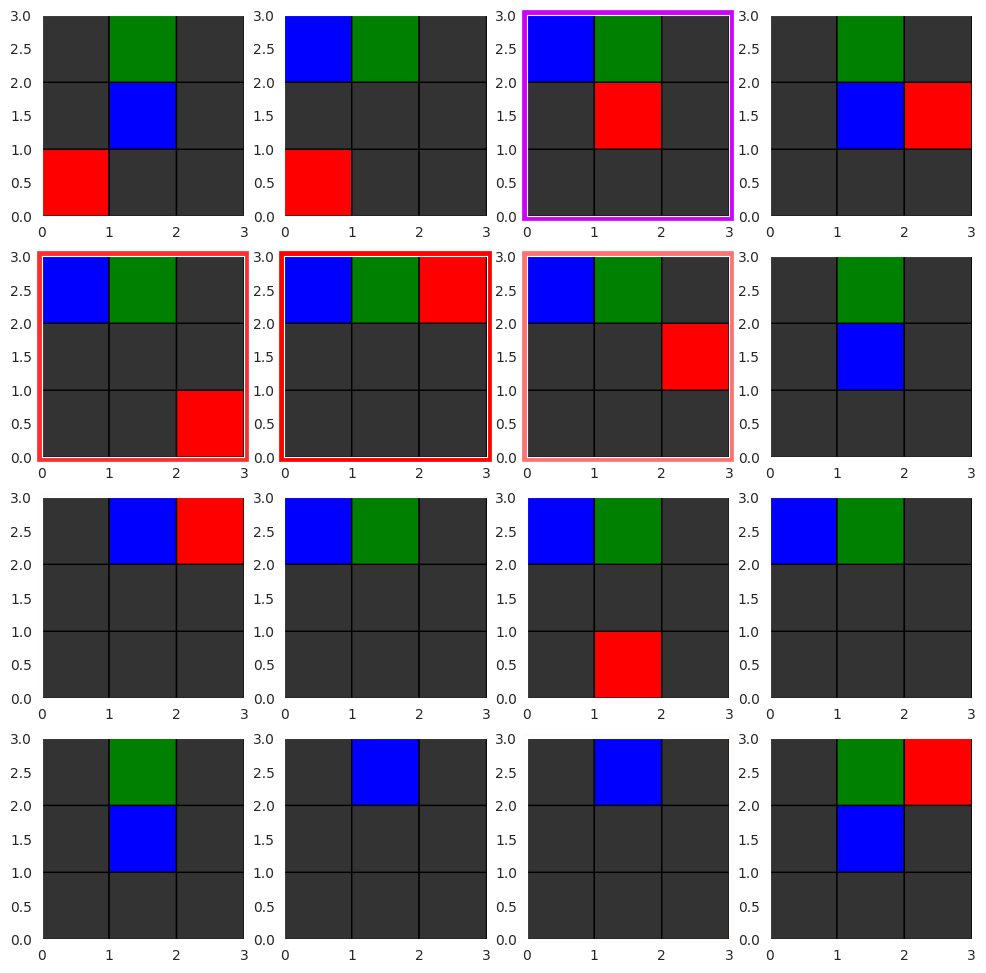

In [80]:
border_colors = np.array(map01(jx.nn.softmax(prior_probs)))

print('Predicted:')
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    predicted_obs, logits = next_obs_func(
        next_obs_params,
        obs,
        jnp.eye(num_actions)[action0],
        quantize_fun.apply(encoder_params, encoder_state, i)[0],
        key)
    render_obs(predicted_obs, ax)
    ax.patch.set_linewidth(7)

    color = (1, 0, 0, border_colors[i])
    if i == encoding_ind:
        color = (border_colors[i], 0, 1, 1)
    ax.patch.set_edgecolor(color)

In [81]:
seeds = 1000
correct_percentages = []
for seed in range(seeds):
    key = jx.random.PRNGKey(seed)
    seed_id = 1
    stat, ob = env.reset(key)
    goal, enemy_coords, _ = stat
    action = jx.random.choice(key, num_actions)
    ac_state, ac_obs, ac_rew, ac_terminal, _ = env.step(subkey, stat, action)
    _, _, pos = ac_state

    num_possibly_correct = 0

    possible_states = 0
    found_states = 0.0
    prior_probs_pred = embedding_prior_func(embedding_prior_params, ob, jnp.eye(num_actions)[action])['logits']
    top_k = jnp.argpartition(prior_probs_pred, -4)[-4:]
    for mov in range(1, 5):
        # Move if the new position is on the grid
        enemy_pos = jnp.clip(enemy_coords + env.move_map[mov], 0, env.grid_size - 1)
        if jnp.array_equal(enemy_pos, enemy_coords):
            continue
        possible_states += 1
        possible_state = (goal, enemy_pos, pos)
        poss_obs = env.get_observation(possible_state)

        # print("possible_state")
        # render(possible_state)
        # plt.show()

        for i in top_k:
            predicted_obs, logits = next_obs_func(
                next_obs_params,
                ob,
                jnp.eye(num_actions)[action],
                quantize_fun.apply(encoder_params, encoder_state, i)[0],
                key)
            obs_precise = logits['logit'] > 0

            if jnp.array_equal(predicted_obs, poss_obs):
                # print("predicted")
                # render_obs(predicted_obs)
                # plt.show()
                found_states += 1
                break

    correct_percentages.append(found_states / possible_states)

Counter(correct_percentages)

Counter({1.0: 905,
         0.0: 42,
         0.6666666666666666: 19,
         0.5: 15,
         0.3333333333333333: 13,
         0.75: 3,
         0.25: 3})

<BarContainer object of 7 artists>

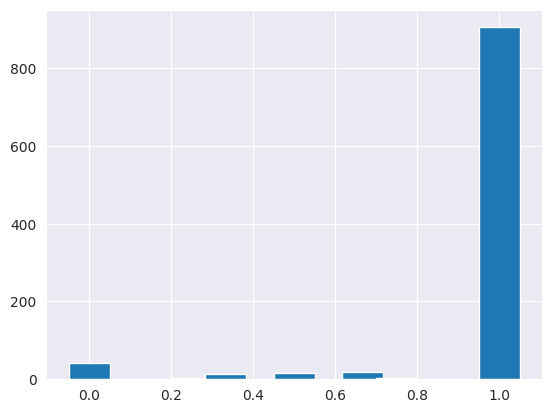

In [84]:
counter = Counter(correct_percentages)
plt.bar(counter.keys(), counter.values(), width=0.1)
